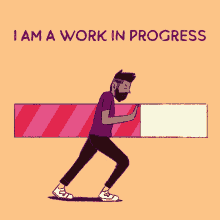

## Import pakages

In [5]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import random

## Read images

In [6]:
path = r'C:\Users\swini\Desktop\Python\CelebFaces'

img_rows = 256
img_cols = 256
channels = 3

X = []

for i in os.listdir(path):
    if i.endswith('.png'):
        image = cv2.imread(path + '/' + i)
        image = image.astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_rows, img_cols))
        X.append(image)  

In [7]:
X = np.array(X)

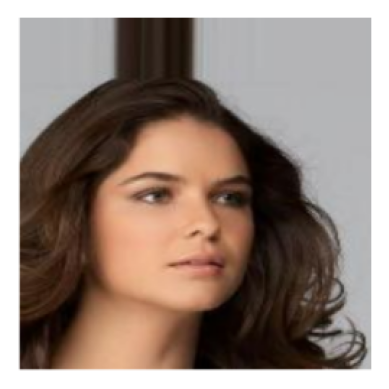

In [8]:
i = X[0]
plt.figure()
plt.axis('off')
plt.imshow(i)
plt.show()

## Set images in random order

In [9]:
random.shuffle(X)

## Convert to grayscale 

In [10]:
X_gray = np.array([cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY) for i in range(len(X))])

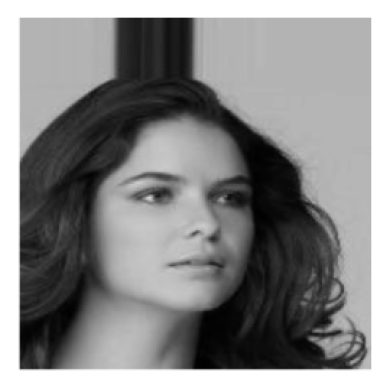

In [11]:
plt.figure()
plt.axis('off')
plt.imshow(X_gray[0], cmap='gray')
plt.show()

## Train Test Split 

In [12]:
#split in proportion 80/20
percent = int(len(X)*0.8)
X_train, X_test = X[:percent], X[percent:]
X_train_gray, X_test_gray = X_gray[:percent], X_gray[percent:]

## Images normalization

In [13]:
#RGB images
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

#Grayscale images
X_train_gray = X_train_gray.astype('float32')/255
X_test_gray = X_test_gray.astype('float32')/255

## Network's parameters

In [14]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
strides = 2
activation = 'relu'
padding = 'same'
latent_dim = 256
layer_filters = [64, 128, 256]

## Encoder

In [15]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              activation=activation,
              padding=padding)(x)
    
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 latent_vector (Dense)       (None, 256)               67109120  
                                                                 
Total params: 67,478,784
Trainable params: 67,478,784
Non-t

## Decoder

In [16]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       activation=activation,
                       padding=padding)(x)
    
outputs = Conv2DTranspose(filters=channels, 
                         kernel_size=kernel_size,
                         activation='sigmoid',
                         padding=padding,
                         name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 262144)            67371008  
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 128)    295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 64)     7379

## Autoencoder

In [17]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 256)               67478784  
                                                                 
 decoder (Functional)        (None, 256, 256, 3)       68331651  
                                                                 
Total params: 135,810,435
Trainable params: 135,810,435
Non-trainable params: 0
_________________________________________________________________


## Learning rate reducer

In [22]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                             cooldown=0,
                             patience=5,
                             verbouse=1,
                             min_lr=0.5e-6)

## Compilation

In [24]:
autoencoder.compile(loss='mse', optimizer='adam')

## Fit

In [27]:
autoencoder.fit(X_train_gray,
               X_train,
               validation_data=(X_test_gray, X_test),
               epochs=10,
               batch_size=batch_size,
               callbacks=lr_reducer)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0990 - val_loss: 0.1193 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0989 - val_loss: 0.1192 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0988 - val_loss: 0.1190 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0987 - val_loss: 0.1188 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0985 - val_loss: 0.1186 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0983 - val_loss: 0.1183 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0981 - val_loss: 0.1179 - lr: 0.0010
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0979 - val_loss: 0.1174 - lr: 0.0010
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0976 - val_loss: 0.1169 - lr: 0.0010
Epoch 10/10
1/1 [===========

In [30]:
X_decoded = autoencoder.predict(X_test_gray[:12])

1/1 [==============================] - 0s 130ms/step


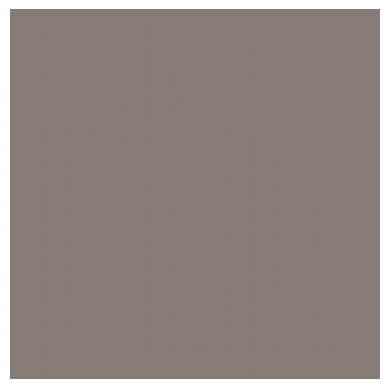

In [33]:
imgs = X_decoded
imgs = imgs.reshape((3, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(1) for i in imgs])
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none')